## Toinen neuroverkkokurssin menetelmätehtävä                                   Ville Kurikka

Aloitetaan lataamalla tarpeellisia importteja, ja lataamalla datasetti. Varataan 20 prosenttia riveistä lopulliseen testaamiseen.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.datasets import california_housing


(inputs, targets), (x_test, y_test) = california_housing.load_data(version='large', 
                                        test_split=0.2)





[2.523   1.469   2.909   ... 5.00001 4.99    2.381  ]


Jaetaan jäljelle jäänyt osuus training- ja validation dataseteiksi. 60 % kokonaismääräistä käytetään mallin opettamiseen, ja 20 % käytetään validointivaiheessa parametrien säätöön.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    inputs, targets, test_size=0.25, random_state=42
)

print('Training shapes:', x_train.shape, y_train.shape)
print('Validation shapes:', x_val.shape, y_val.shape)


Training shapes: (12384, 8) (12384,)
Validation shapes: (4128, 8) (4128,)


Standardisoidaan data

In [10]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_val -= mean
x_val /= std
x_test -= mean
x_test /= std

y_train /= 1e5
y_val /= 1e5
y_test /= 1e5

Aloitetaan mallin rakennus. Tehdään siis aluksi malli, joka selkeästi ylioppii

In [11]:
model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=0)

Text(0, 0.5, 'Loss')

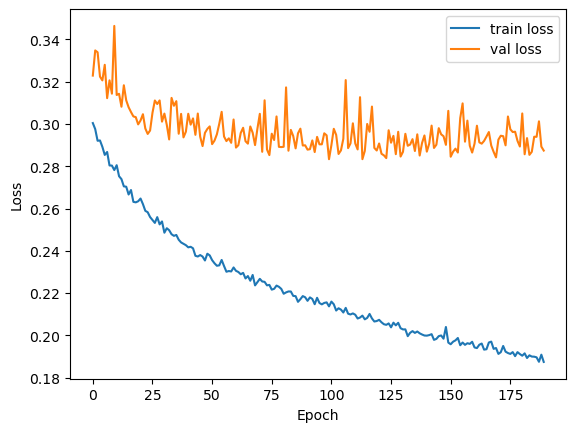

In [12]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

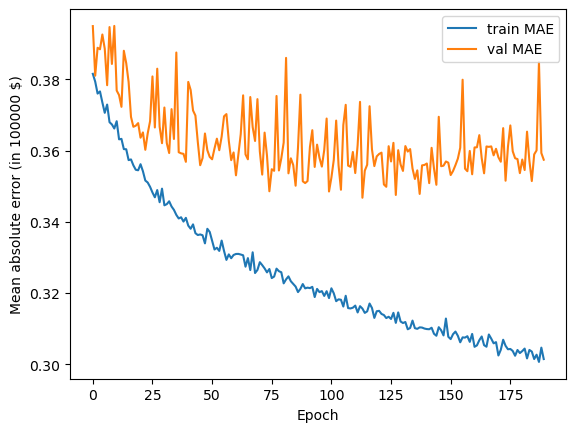

In [13]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

Kuvaajien perusteella mallissa tapahtuu ylioppimista, sillä vaikka train loss ja train MAE laskevat tasaisesti, niin validation loss ja val MAE näyttävät pysyvän samoissa lukemissa tai jopa hieman kasvavan.